In [2]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from autoencoder_wsindy import full_network
from training_wsindy import create_feed_dictionary, create_feed_dictionary2, eval_model, max_err_heatmap, NN
from wsindy_utils import *
from error_utils import *
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from time import time
from copy import deepcopy
import subprocess as sp
%matplotlib inline
import random
from sklearn.linear_model import LinearRegression
import copy
from scipy.integrate import solve_ivp
from sindy_utils import derivative2

def get_cmap(n, name='tab20'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 9734
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 13028
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 14039
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 11868


In [4]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,
                                                                              visible_device_list='1'))

## Load the Trained WgLaSDI

In [5]:
data_path = os.getcwd() + '/fig/nDI25/'
save_name = 'vlasov_2024_04_08_23_51_51'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
params['config'] = config

print(params['loss_weight_decoder'], params['loss_weight_wsindy_x'], params['loss_weight_wsindy_z'],params['loss_weight_wsindy_regularization'])
print(params['learning_rate'])
print(params['widths'])
print(params['activation'])
print(params['L'])
print(params['latent_dim'],params['poly_order'],params['include_cosine'])
print(params['epoch_count'])

1 10 100 0.0001
0.001
[1000, 100, 50, 50, 50]
relu
12
3 1 False
715006


## Evaluation by One Parameter Case

In [ ]:
knn = 1
w1 = 0.9
w2 = 1.0
tstop = 5
t_test = tstop
nt = 251
noise_ratio = 0.0
# if noise_ratio > 0:
#     test_data = pickle.load(open(f"/usr/workspace/he10/data/Vlasov1D1V/1_p1_{w1:.2f}_p2_{w2:.2f}_tstop{tstop:.2f}_nt{nt}_noise{noise_ratio:.2f}.p", "rb"))
# else:
#     test_data = pickle.load(open(f"/usr/workspace/he10/data/Vlasov1D1V/1_p1_{w1:.2f}_p2_{w2:.2f}_tstop{tstop:.2f}_nt{nt}.p", "rb"))

if noise_ratio > 0:
    test_data = pickle.load(open(f"/usr/workspace/he10/data/Vlasov1D1V/1_p1_{w1:.2f}_p2_{w2:.2f}_tstop{tstop:.2f}_nt{nt}_noise{noise_ratio:.2f}_normalized.p", "rb"))
else:
    test_data = pickle.load(open(f"/usr/workspace/he10/data/Vlasov1D1V/1_p1_{w1:.2f}_p2_{w2:.2f}_tstop{tstop:.2f}_nt{nt}_normalized.p", "rb"))
    
t = np.linspace(0,t_test,nt)

test_data_x = test_data['data'][0]['x']
test_data_dx = test_data['data'][0]['dx']

In [6]:
nx = 64
nv = 64
x_min = 0
x_max = 6.2340979219672459E+00
v_min = -7
v_max = 6.8906250000000000E+00
x_mesh = np.linspace(x_min, x_max, nx)
v_mesh = np.linspace(v_min, v_max, nv)
x_mesh, v_mesh = np.meshgrid(x_mesh, v_mesh)
scale = 1

(251, 3) (251, 4096) (251, 4096)


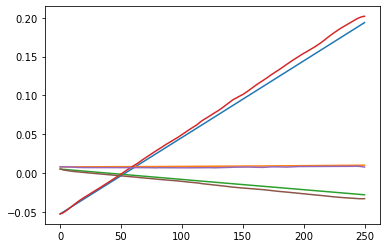

In [7]:
u_decoder,du_decoder,u_sim,du_sim,z_encoder,dz_encoder,z_sim,dz_sim,idx,timer_rom = eval_model(test_data['data'][0], params,
                                                                                               test_data['param'][0], knn=knn,
                                                                                               calc_dz=True, calc_du=True)
u_decoder = u_decoder.squeeze()
print(z_sim.shape, u_sim.shape, u_decoder.shape)

In [8]:
# max relative error
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_sindy = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max sindy-decoder error: {err_sindy.max():.2f} %')

max autoencoder error: 3.86 %
max sindy-decoder error: 13.19 %


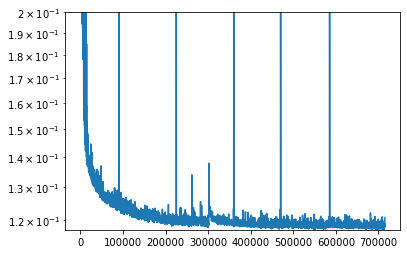

In [9]:
loss = []
for i in range(len(params['training_losses'])):
    loss.append(params['training_losses'][i][0])
xp = np.linspace(1,params['epoch_count'],len(params['training_losses']))
plt.plot(xp,loss)
# plt.ylim([9e-2, 6e-1])
# plt.xlim([3e4, 4.6e4])
plt.ylim([min(loss), 2e-1])
plt.yscale('log')

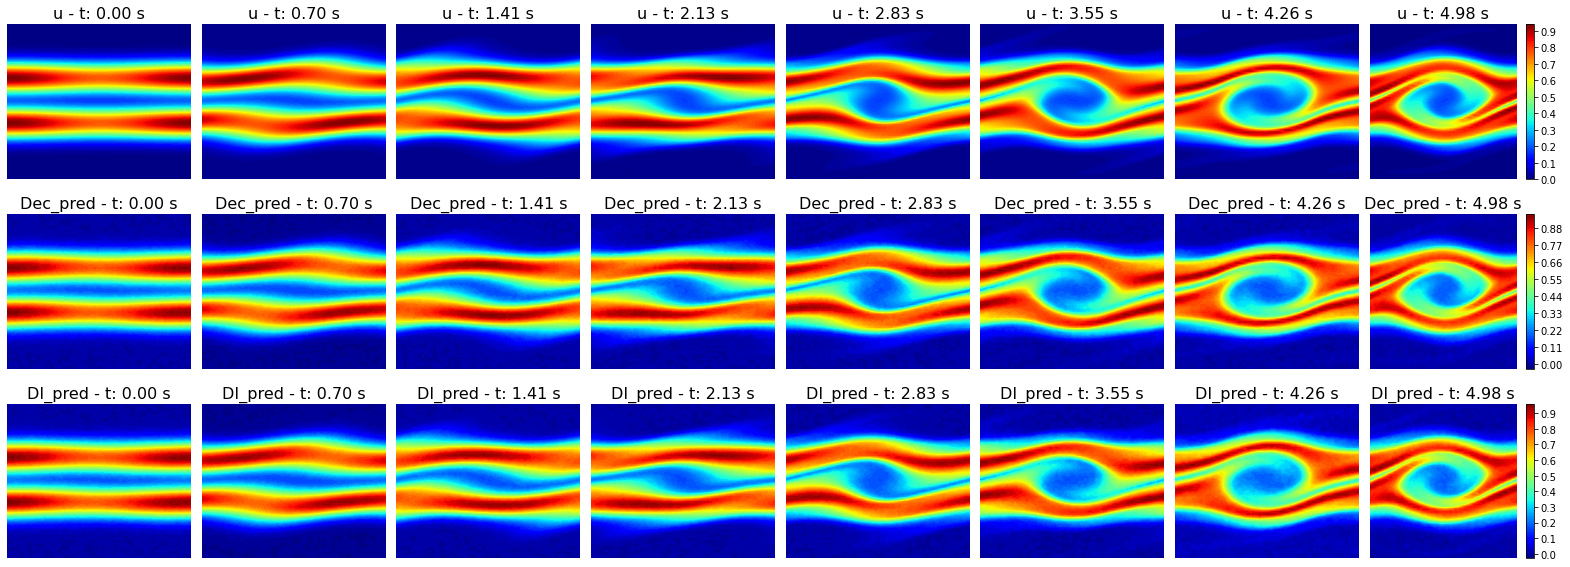

In [10]:
nplot = 8
nt = test_data['data'][0]['x'].shape[0]
step_list = np.linspace(0,nt-1,nplot,dtype=int)

nx = 64
nv = 64
x_min = 0
x_max = 6.2340979219672459E+00
v_min = -7
v_max = 6.8906250000000000E+00
x_mesh = np.linspace(x_min, x_max, nx)
v_mesh = np.linspace(v_min, v_max, nv)
x_mesh, v_mesh = np.meshgrid(x_mesh, v_mesh)
scale = 1

fig = plt.figure(figsize=(22,8))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(3,nplot,i+1)
    ax = plt.gca()
    plt.contourf(x_mesh, v_mesh, test_data['data'][0]['x'][step].reshape(nx, nv), 100, cmap=plt.cm.jet)
    if i == nplot-1: plt.colorbar()
    ax.set_title(f'u - t: {step/nt*tstop:.2f} s',fontsize=16)
    plt.axis('off')
    
for i,step in enumerate(step_list):
    ax = fig.add_subplot(3,nplot,i+1+nplot)
    ax = plt.gca()
    plt.contourf(x_mesh, v_mesh, u_decoder[step].reshape(nx, nv), 100, cmap=plt.cm.jet)
    if i == nplot-1: plt.colorbar()
    ax.set_title(f'Dec_pred - t: {step/nt*tstop:.2f} s',fontsize=16)
    plt.axis('off')

for i,step in enumerate(step_list):
    ax = fig.add_subplot(3,nplot,i+1+2*nplot)
    ax = plt.gca()
    plt.contourf(x_mesh, v_mesh, u_sim[step].reshape(nx, nv), 100, cmap=plt.cm.jet)
    if i == nplot-1: plt.colorbar()
    ax.set_title(f'DI_pred - t: {step/nt*tstop:.2f} s',fontsize=16)
    plt.axis('off')
plt.tight_layout()

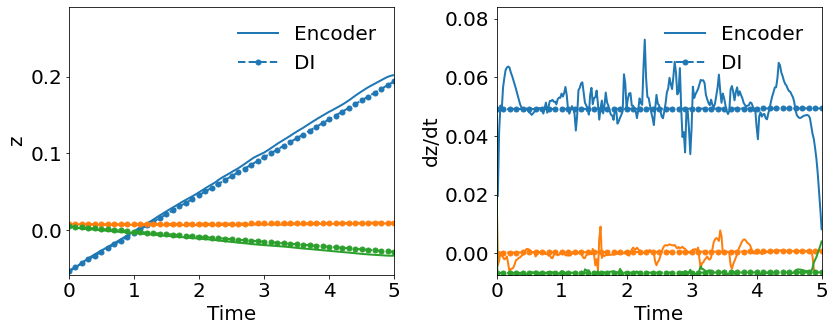

In [11]:
plt.rcParams.update({"font.size": 20,
                     "font.family": "sans-serif"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,5)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
    # ax.plot(t[idx], z[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),6))
ax.set_ylim(z_sim.min()*1.1,z_sim.max()*1.5)
ax.tick_params(axis='both', labelsize=20)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=20)
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sim[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
    # ax.plot(t[idx], dz_sindy[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),6))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sim.min()*1.1,dz_sim.max()*1.7)
ax.tick_params(axis='both', labelsize=20)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=20)

plt.tight_layout()
plt.savefig(data_path + f"advection_latent_dynamics.png",bbox_inches='tight')

## Evaluation by the Prescribed Parameter Space

0/441: [0.9 1. ]
1/441: [0.91 1.  ]
2/441: [0.92 1.  ]
3/441: [0.93 1.  ]
4/441: [0.94 1.  ]
5/441: [0.95 1.  ]
6/441: [0.96 1.  ]
7/441: [0.97 1.  ]
8/441: [0.98 1.  ]
9/441: [0.99 1.  ]
10/441: [1. 1.]
11/441: [1.01 1.  ]
12/441: [1.02 1.  ]
13/441: [1.03 1.  ]
14/441: [1.04 1.  ]
15/441: [1.05 1.  ]
16/441: [1.06 1.  ]
17/441: [1.07 1.  ]
18/441: [1.08 1.  ]
19/441: [1.09 1.  ]
20/441: [1.1 1. ]
21/441: [0.9  1.01]
22/441: [0.91 1.01]
23/441: [0.92 1.01]
24/441: [0.93 1.01]
25/441: [0.94 1.01]
26/441: [0.95 1.01]
27/441: [0.96 1.01]
28/441: [0.97 1.01]
29/441: [0.98 1.01]
30/441: [0.99 1.01]
31/441: [1.   1.01]
32/441: [1.01 1.01]
33/441: [1.02 1.01]
34/441: [1.03 1.01]
35/441: [1.04 1.01]
36/441: [1.05 1.01]
37/441: [1.06 1.01]
38/441: [1.07 1.01]
39/441: [1.08 1.01]
40/441: [1.09 1.01]
41/441: [1.1  1.01]
42/441: [0.9  1.02]
43/441: [0.91 1.02]
44/441: [0.92 1.02]
45/441: [0.93 1.02]
46/441: [0.94 1.02]
47/441: [0.95 1.02]
48/441: [0.96 1.02]
49/441: [0.97 1.02]
50/441: [0.98 1.02

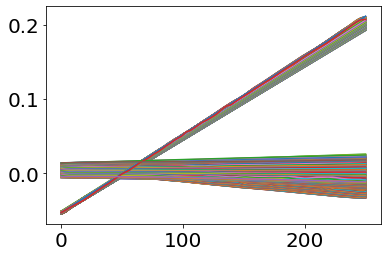

In [12]:
knn = 4
res_name = f'mean'

na = 21
nw = na
p1_test = np.linspace(0.9, 1.1, na)
p2_test = np.linspace(1.0, 1.2, nw)
num_case = p1_test.size * p2_test.size
max_err = np.zeros([len(p1_test), len(p2_test)])
res_norm = np.zeros([len(p1_test), len(p2_test)])
sindy_idx = np.zeros([len(p1_test), len(p2_test)])
# test_data_all = pickle.load(open(f"/usr/workspace/he10/data/Vlasov1D1V/{num_case}_m{nx}_tstop{tstop:.2f}_nt{nt}.p", "rb"))
test_data_all = pickle.load(open(f"/usr/workspace/he10/data/Vlasov1D1V/{num_case}_m{nx}_tstop{tstop:.2f}_nt{nt}_normalized.p", "rb"))

speed_up = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(p1_test):
    for j,w in enumerate(p2_test):
        print(f"{count}/{num_case}: {test_data_all['param'][count]}")
        test_data = {}
        test_data['data'] = [deepcopy(test_data_all['data'][count])]
        test_data['param'] = [deepcopy(test_data_all['param'][count])]
        
        _,_,u_sim,_,_,_,_,_,idx,t_rom = eval_model(test_data['data'][0], params, 
                                                   test_data['param'][0], knn=knn)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # Max error of all time steps
        max_err[i,j] = (np.linalg.norm(test_data['data'][0]['x'] - u_sim, axis=1) \
                        / np.linalg.norm(test_data['data'][0]['x'], axis=1)*100).max()
        
        # residual norm
        params['pde']['param'] = [a, w] # the parameter values of the testing case
        res_norm[i,j] = err_indicator(u_sim, params, test_data['data'][0]['x'], err_type=params['err_type'])
        count += 1

end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 3.8 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Max relative error: {max_err.max() :.2f} %')
print(f'Average speed up: {speed_up:.2f}')

In [13]:
a_grid, w_grid = np.meshgrid(p1_test, p2_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])
a_grid, w_grid = np.meshgrid(np.arange(p1_test.size), np.arange(p2_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

idx_param = []
for i,ip in enumerate(params['param']):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

idx: 0, param: [0.9 1. ]
idx: 5, param: [0.95 1.  ]
idx: 10, param: [1. 1.]
idx: 15, param: [1.05 1.  ]
idx: 20, param: [1.1 1. ]
idx: 105, param: [0.9  1.05]
idx: 110, param: [0.95 1.05]
idx: 115, param: [1.   1.05]
idx: 120, param: [1.05 1.05]
idx: 125, param: [1.1  1.05]
idx: 210, param: [0.9 1.1]
idx: 215, param: [0.95 1.1 ]
idx: 220, param: [1.  1.1]
idx: 225, param: [1.05 1.1 ]
idx: 230, param: [1.1 1.1]
idx: 315, param: [0.9  1.15]
idx: 320, param: [0.95 1.15]
idx: 325, param: [1.   1.15]
idx: 330, param: [1.05 1.15]
idx: 335, param: [1.1  1.15]
idx: 420, param: [0.9 1.2]
idx: 425, param: [0.95 1.2 ]
idx: 430, param: [1.  1.2]
idx: 435, param: [1.05 1.2 ]
idx: 440, param: [1.1 1.2]


../../src/training_wsindy.py:730: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


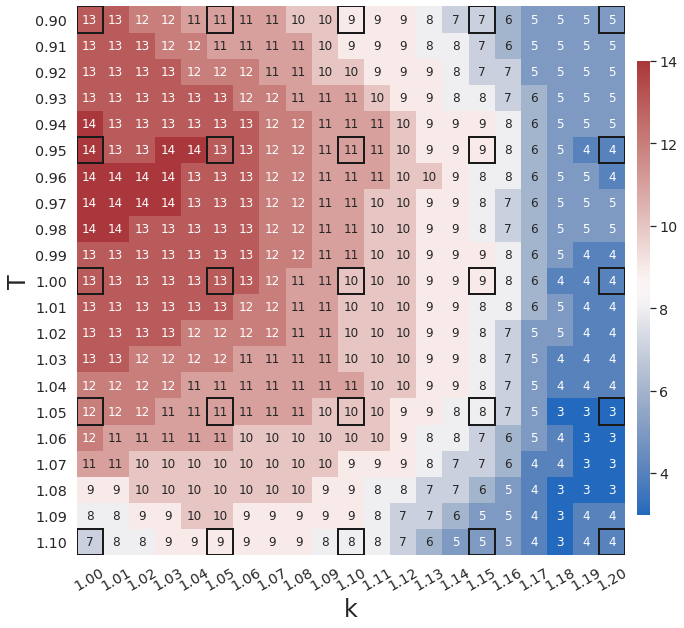

In [14]:
max_err_heatmap(max_err, sindy_idx, params, p1_test, p2_test, data_path, idx_list, idx_param,
                xlabel='k', ylabel='T', dtype='float')